<a href="https://colab.research.google.com/github/EliabeBastosDias/analise-de-vinhos-portugueses/blob/main/densenet_121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Combined All the dataset in one place

# Labeling

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

BASE = "/kaggle/input"

paths = {
    "brain": "/kaggle/input/fetal-brain-anomalies-ultrasound-1/content/drive/MyDrive/Dataset/Fetal-Brain-1.8k",

    "fetal_planes": "/kaggle/input/fetal-planes-db-dataset/Fetal_Planes_DB",

    # Heart 4-chamber — include all three subfolders
    "heart_4ch_training": "/kaggle/input/fetal-heart-four-chamber-ultrasound-image/training/images",
    "heart_4ch_validation": "/kaggle/input/fetal-heart-four-chamber-ultrasound-image/validation/images",
    "heart_4ch_testing": "/kaggle/input/fetal-heart-four-chamber-ultrasound-image/testing/images",

    "heart_ft": "/kaggle/input/first-trimester-fetal-echocardiography/Fetal Echocardiography First Trimester",

    "nt_dataset": "/kaggle/input/dataset-for-fetus-framework/Dataset for Fetus Framework",

    "maternal_fetal_planes": "/kaggle/input/maternal-fetal-ultrasound-planes/dataset"
}


# ---------------------------------------------------------
# LABELING FUNCTION
# ---------------------------------------------------------
def get_label(img_path):
    p = img_path.lower()

    # -----------------------------
    # BRAIN (normal + abnormal)
    # -----------------------------
    if "fetal-brain-1.8k" in p or "fetal-brain-abnormalities" in p:
        if "hc" in p or "thal" in p:
            return "brain-hc"            # Combine HC + thalamic into a single class
        if "vent" in p:
            return "brain-ventricular"
        if "cerebell" in p:
            return "brain-cerebellum"
        return "unknown"

    # -----------------------------
    # HEART 4CH — ONLY images folder
    # -----------------------------
    if "fetal-heart-four-chamber-ultrasound-image" in p:
        parent_folder = os.path.basename(os.path.dirname(p))
        if parent_folder == "images":
            return "heart-4ch"

    # -----------------------------
    # FIRST TRIMESTER HEART (3V, 3VT, etc.)
    # -----------------------------
    if "fetal echocardiography first trimester" in p:
        if "/v sign" in p or "/x sign" in p:
            return "heart-3vt"
        if "/aorta" in p or "/flows" in p:
            return "heart-3v"
        if "/other" in p:
            return "heart-other"
        return "unknown"

    # -----------------------------
    # NT DATASET
    # -----------------------------
    if "dataset for fetus framework" in p:
        if "/standard" in p:
            return "mid-sagittal-standard"
        if "/non-standard" in p:
            return "mid-sagittal-nonstandard"
        return "unknown"

    # -----------------------------
    # FETAL PLANES DB
    # -----------------------------
    if "fetal_planes_db" in p or "fetal-planes-db-dataset" in p:
        if "fetal abdomen" in p:
            return "abdomen"
        if "fetal brain" in p:
            return "brain-hc"  # Combine HC + thalamic here
        if "fetal femur" in p:
            return "femur"
        if "fetal thorax" in p:
            return "thorax"
        if "maternal cervix" in p:
            return "cervix"
        return "unknown"

    # -----------------------------
    # maternal-fetal dataset
    # -----------------------------
    if "maternal-fetal-ultrasound-planes" in p:
        if "hc" in p or "trans-thalamic" in p:
            return "brain-hc"  # Combine HC + thalamic here
        if "trans-ventricular" in p:
            return "brain-ventricular"
        if "trans-cerebellum" in p:
            return "brain-cerebellum"
        return "unknown"

    return "unknown"


# ---------------------------------------------------------
# COLLECT IMAGES
# ---------------------------------------------------------
all_rows = []

def add_images(root):
    for r, d, f in os.walk(root):
        for file in f:
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                full = os.path.join(r, file)
                label = get_label(full)
                all_rows.append([full, label])


for key, path in paths.items():
    if os.path.exists(path):
        print("Scanning:", path)
        add_images(path)
    else:
        print("Missing:", path)


# ---------------------------------------------------------
# SAVE CSV
# ---------------------------------------------------------
df = pd.DataFrame(all_rows, columns=["image_path", "label"])
csv_path = "/kaggle/working/final_labels.csv"
df.to_csv(csv_path, index=False)

print("DONE! Total images:", len(df))
df.head()


Scanning: /kaggle/input/fetal-brain-anomalies-ultrasound-1/content/drive/MyDrive/Dataset/Fetal-Brain-1.8k
Scanning: /kaggle/input/fetal-planes-db-dataset/Fetal_Planes_DB
Scanning: /kaggle/input/fetal-heart-four-chamber-ultrasound-image/training/images
Scanning: /kaggle/input/fetal-heart-four-chamber-ultrasound-image/validation/images
Scanning: /kaggle/input/fetal-heart-four-chamber-ultrasound-image/testing/images
Scanning: /kaggle/input/first-trimester-fetal-echocardiography/Fetal Echocardiography First Trimester
Scanning: /kaggle/input/dataset-for-fetus-framework/Dataset for Fetus Framework
Scanning: /kaggle/input/maternal-fetal-ultrasound-planes/dataset
DONE! Total images: 26820


,image_path,label
0,/kaggle/input/fetal-brain-anomalies-ultrasound...,unknown
1,/kaggle/input/fetal-brain-anomalies-ultrasound...,brain-ventricular
2,/kaggle/input/fetal-brain-anomalies-ultrasound...,unknown
3,/kaggle/input/fetal-brain-anomalies-ultrasound...,brain-ventricular
4,/kaggle/input/fetal-brain-anomalies-ultrasound...,brain-cerebellum


# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Load CSV + Filter Classes

In [ ]:
# Load the CSV you already created
csv_path = "/kaggle/working/final_labels.csv"
df = pd.read_csv(csv_path)

# Keep only the 9 relevant classes
valid_classes = [
    'brain-cerebellum','brain-hc','brain-ventricular',
    'heart-3v','heart-3vt','heart-4ch','heart-other',
    'mid-sagittal-nonstandard','mid-sagittal-standard'
]
df = df[df['label'].isin(valid_classes)].reset_index(drop=True)
print("Filtered CSV shape:", df.shape)
print("Classes:", df['label'].unique())


Filtered CSV shape: (16560, 2)
Classes: ['brain-ventricular' 'brain-cerebellum' 'brain-hc' 'heart-4ch' 'heart-3v'
 'heart-other' 'heart-3vt' 'mid-sagittal-nonstandard'
 'mid-sagittal-standard']


# Encode Labels + Split Train/Validation

In [ ]:
# Encode labels to 0-8
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)

# Split into train/val (stratified)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))


Train size: 13248
Validation size: 3312


# Dataset Class

In [ ]:
class FetalPlaneDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = row['label_encoded']
        return img, label


# Transforms + DataLoaders

In [ ]:
# Light medical-safe augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_ds = FetalPlaneDataset(train_df, train_transforms)
val_ds   = FetalPlaneDataset(val_df, val_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)


# Compute Class Weights

In [ ]:
class_counts = train_df['label_encoded'].value_counts().sort_index().values
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.max()  # normalize
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights_tensor)


Class weights: tensor([0.3556, 0.0524, 0.2339, 0.1655, 0.1429, 1.0000, 0.1069, 0.6154, 0.2505],
       device='cuda:0')


# DenseNet-121 Model

In [ ]:
model = models.densenet121(weights="IMAGENET1K_V1")
model.classifier = nn.Linear(1024, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Training & Validation Functions

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(outputs.argmax(1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc

def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc


# Train the Model

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate_one_epoch(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f" Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")


Epoch 1/20
 Train Loss: 0.5118 | Train Acc: 77.76%
 Val Loss:   0.2479 | Val Acc:   83.64%
Epoch 2/20
 Train Loss: 0.2523 | Train Acc: 84.36%
 Val Loss:   0.2103 | Val Acc:   86.84%
Epoch 3/20
 Train Loss: 0.1954 | Train Acc: 86.53%
 Val Loss:   0.2256 | Val Acc:   81.25%
Epoch 4/20
 Train Loss: 0.1745 | Train Acc: 86.93%
 Val Loss:   0.2804 | Val Acc:   85.63%
Epoch 5/20
 Train Loss: 0.1545 | Train Acc: 87.70%
 Val Loss:   0.2037 | Val Acc:   86.26%
Epoch 6/20
 Train Loss: 0.1487 | Train Acc: 88.07%
 Val Loss:   0.1681 | Val Acc:   86.87%
Epoch 7/20
 Train Loss: 0.1387 | Train Acc: 88.50%
 Val Loss:   0.2116 | Val Acc:   86.26%
Epoch 8/20
 Train Loss: 0.1278 | Train Acc: 89.30%
 Val Loss:   0.2225 | Val Acc:   88.35%
Epoch 9/20
 Train Loss: 0.1245 | Train Acc: 89.09%
 Val Loss:   0.2247 | Val Acc:   83.00%
Epoch 10/20
 Train Loss: 0.1279 | Train Acc: 89.21%
 Val Loss:   0.2216 | Val Acc:   87.08%
Epoch 11/20
 Train Loss: 0.1247 | Train Acc: 89.34%
 Val Loss:   0.2391 | Val Acc:   86.9

# Confusion Matrix & Classification Report

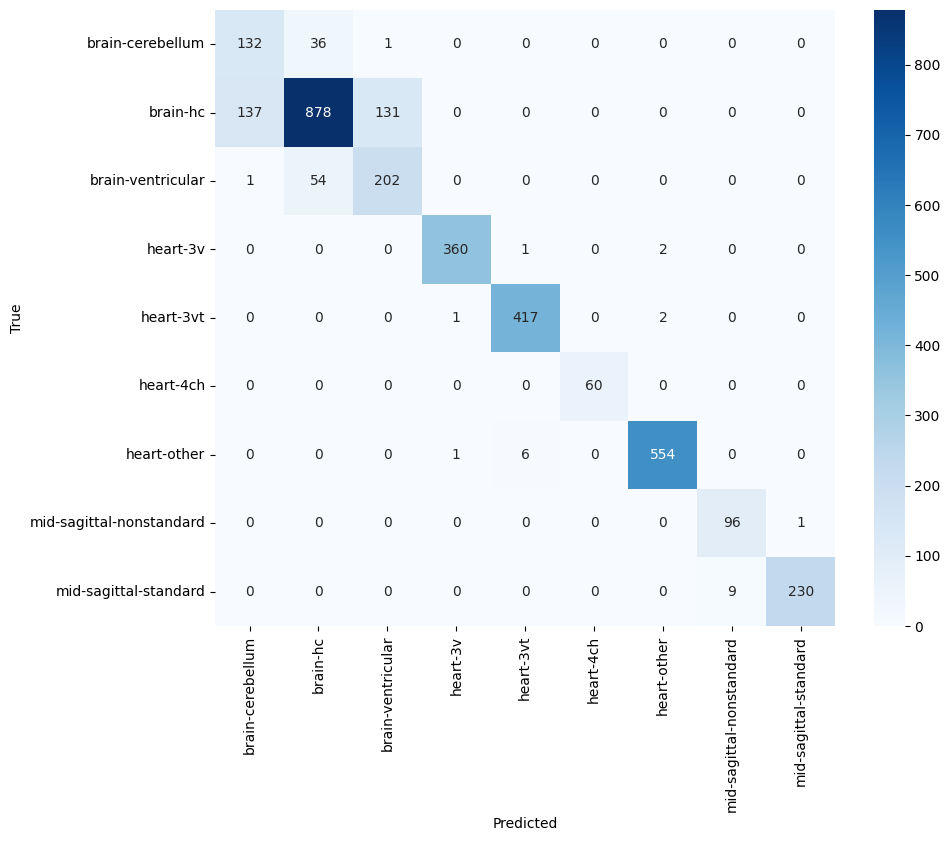

                          precision    recall  f1-score   support

        brain-cerebellum       0.49      0.78      0.60       169
                brain-hc       0.91      0.77      0.83      1146
       brain-ventricular       0.60      0.79      0.68       257
                heart-3v       0.99      0.99      0.99       363
               heart-3vt       0.98      0.99      0.99       420
               heart-4ch       1.00      1.00      1.00        60
             heart-other       0.99      0.99      0.99       561
mid-sagittal-nonstandard       0.91      0.99      0.95        97
   mid-sagittal-standard       1.00      0.96      0.98       239

                accuracy                           0.88      3312
               macro avg       0.88      0.92      0.89      3312
            weighted avg       0.90      0.88      0.89      3312



In [ ]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds.extend(outputs.argmax(1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(trues, preds, target_names=le.classes_))


In [ ]:
# If you have a separate test CSV or folder, load it
# For demonstration, using val_df as test set
test_df = val_df.copy()

class FetalTestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row['image_path']  # return path for saving

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_ds = FetalTestDataset(test_df, test_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# ------------------------
# Predict
# ------------------------
model.eval()
pred_labels = []

with torch.no_grad():
    for imgs, paths in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        pred_labels.extend(preds)

# Map numeric labels back to class names
pred_class_names = le.inverse_transform(pred_labels)

# Save predictions to CSV
pred_df = pd.DataFrame({
    "image_path": test_df['image_path'],
    "pred_label": pred_class_names
})

pred_csv_path = "/kaggle/working/test_predictions.csv"
pred_df.to_csv(pred_csv_path, index=False)
print(f"Saved predictions to {pred_csv_path}")
pred_df.head()


Saved predictions to /kaggle/working/test_predictions.csv


,image_path,pred_label
10764,/kaggle/input/first-trimester-fetal-echocardio...,heart-3vt
7246,/kaggle/input/first-trimester-fetal-echocardio...,heart-3v
15091,/kaggle/input/maternal-fetal-ultrasound-planes...,brain-hc
7127,/kaggle/input/first-trimester-fetal-echocardio...,heart-3v
9874,/kaggle/input/first-trimester-fetal-echocardio...,heart-3vt


In [ ]:
# Save full model (weights + architecture)
torch.save(model, "/kaggle/working/densenet121_plane_full_model.pth")